In [14]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [15]:
df = pd.read_csv('merged-frame.csv')
print(df.dtypes)
df.head()

order_id             object
order_date           object
status               object
item_id             float64
qty_ordered         float64
price               float64
value               float64
county               object
payment_method       object
category             object
gender               object
age                 float64
user name            object
state                object
discount_percent    float64
year                  int64
month                 int64
actual              float64
forcast             float64
previous            float64
dtype: object


/var/folders/1_/83qhk9ps6fd0yym23nn9nfz00000gn/T/ipykernel_37638/3467590632.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged-frame.csv')


,order_id,order_date,status,item_id,qty_ordered,price,value,county,payment_method,category,gender,age,user name,state,discount_percent,year,month,actual,forcast,previous
0,100354678,2020-10-01 00:00:00+00:00,received,574772.0,21.0,89.9,1798.0,Harmon,cod,Men's Fashion,F,43.0,jwtitus,OK,0.0,2020,10,0.0,0.1,0.2
1,100354678,2020-10-01 00:00:00+00:00,received,574774.0,11.0,19.0,190.0,Harmon,cod,Men's Fashion,F,43.0,jwtitus,OK,0.0,2020,10,0.0,0.1,0.2
2,100354680,2020-10-01 00:00:00+00:00,complete,574777.0,9.0,149.9,1199.2,Harmon,cod,Men's Fashion,F,43.0,jwtitus,OK,0.0,2020,10,0.0,0.1,0.2
3,100354680,2020-10-01 00:00:00+00:00,complete,574779.0,9.0,79.9,639.2,Harmon,cod,Men's Fashion,F,43.0,jwtitus,OK,0.0,2020,10,0.0,0.1,0.2
4,100354677,2020-10-01 00:00:00+00:00,canceled,574769.0,2.0,49.0,49.0,Bradford,Payaxis,Mobiles & Tablets,M,28.0,lseaker,FL,0.0,2020,10,0.0,0.1,0.2


# Data Preperation
I am creating a label in the dataframe to predict if the economic market is currently bullish, critical, or bearish using a classification algorithm. The label is determined by comparing the actual and forecasted consumer price index (CPI). If the actual CPI is higher than the forecasted CPI, the market is considered bullish. If the actual CPI is lower than the forecasted CPI, the market is considered bearish. If the actual and forecasted CPI are equal, I have introduced a third label called critical.

The dataframe includes information such as the order date, the status of the order (received, shipped, or complete), the value of the purchase, the product category, and other relevant details.

In [16]:
#Build labeled data for the response variable
#bullish - bearish - critical
labels = ['bullish' if actual > forcast else 'bearish' if actual < forcast else 'critical' for actual, forcast in zip(df['actual'], df['forcast']) ]
print(len(labels))
df['label'] = pd.Series(np.array(labels))

df_copy = df.copy()
df_copy.to_csv('dashboard.csv', index=False)

df.drop(columns=['user name','actual','forcast','previous', 'order_id','item_id'], axis=1, inplace=True)
df['order_date'] = pd.to_datetime(df['order_date'])
print(df.dtypes)
df.head()


286392
order_date          datetime64[ns, UTC]
status                           object
qty_ordered                     float64
price                           float64
value                           float64
county                           object
payment_method                   object
category                         object
gender                           object
age                             float64
state                            object
discount_percent                float64
year                              int64
month                             int64
label                            object
dtype: object


,order_date,status,qty_ordered,price,value,county,payment_method,category,gender,age,state,discount_percent,year,month,label
0,2020-10-01 00:00:00+00:00,received,21.0,89.9,1798.0,Harmon,cod,Men's Fashion,F,43.0,OK,0.0,2020,10,bearish
1,2020-10-01 00:00:00+00:00,received,11.0,19.0,190.0,Harmon,cod,Men's Fashion,F,43.0,OK,0.0,2020,10,bearish
2,2020-10-01 00:00:00+00:00,complete,9.0,149.9,1199.2,Harmon,cod,Men's Fashion,F,43.0,OK,0.0,2020,10,bearish
3,2020-10-01 00:00:00+00:00,complete,9.0,79.9,639.2,Harmon,cod,Men's Fashion,F,43.0,OK,0.0,2020,10,bearish
4,2020-10-01 00:00:00+00:00,canceled,2.0,49.0,49.0,Bradford,Payaxis,Mobiles & Tablets,M,28.0,FL,0.0,2020,10,bearish


The dataframe has more than 280,000 rows and over 10 features. In order to train the Decision Tree classifier, I one-hot encoded each categorical value in the dataframe. Then, I built a Sklearn Pipeline that standardizes the data before training. Without cross-validation, I achieved an accuracy score of 80%. With 5-fold cross-validation, I obtained an accuracy score of 79%.

In [17]:
## ONE HOT ENCODING
df = pd.get_dummies(df, columns=['status', 'county', 'payment_method', 'category','gender', 'state'])

In [18]:
## building the model

pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', DecisionTreeClassifier(max_depth=100)) #step2 - classifier
])
print(pipeline.steps)

df1 = df.drop(['order_date','year','month'], axis=1)

#Seperate train and test data
X_train, X_test, y_train, y_test = train_test_split(df1.drop('label', axis=1),df1['label'],test_size = 0.4,random_state = 10)

# Fit the decision tree classifier
#clf = DecisionTreeClassifier()
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
cm = confusion_matrix(y_test, y_pred, labels=["bullish","critical","bearish"])
print(f'Test accuracy: {accuracy:.5f}')
print(f'Test F1: {f1:.5f}')
print(cm)




[('normalizer', StandardScaler()), ('clf', DecisionTreeClassifier(max_depth=100))]


KeyboardInterrupt: 

In [6]:
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("%0.5f accuracy with a standard deviation of %0.5f" % (scores.mean(), scores.std()))




0.79660 accuracy with a standard deviation of 0.00058


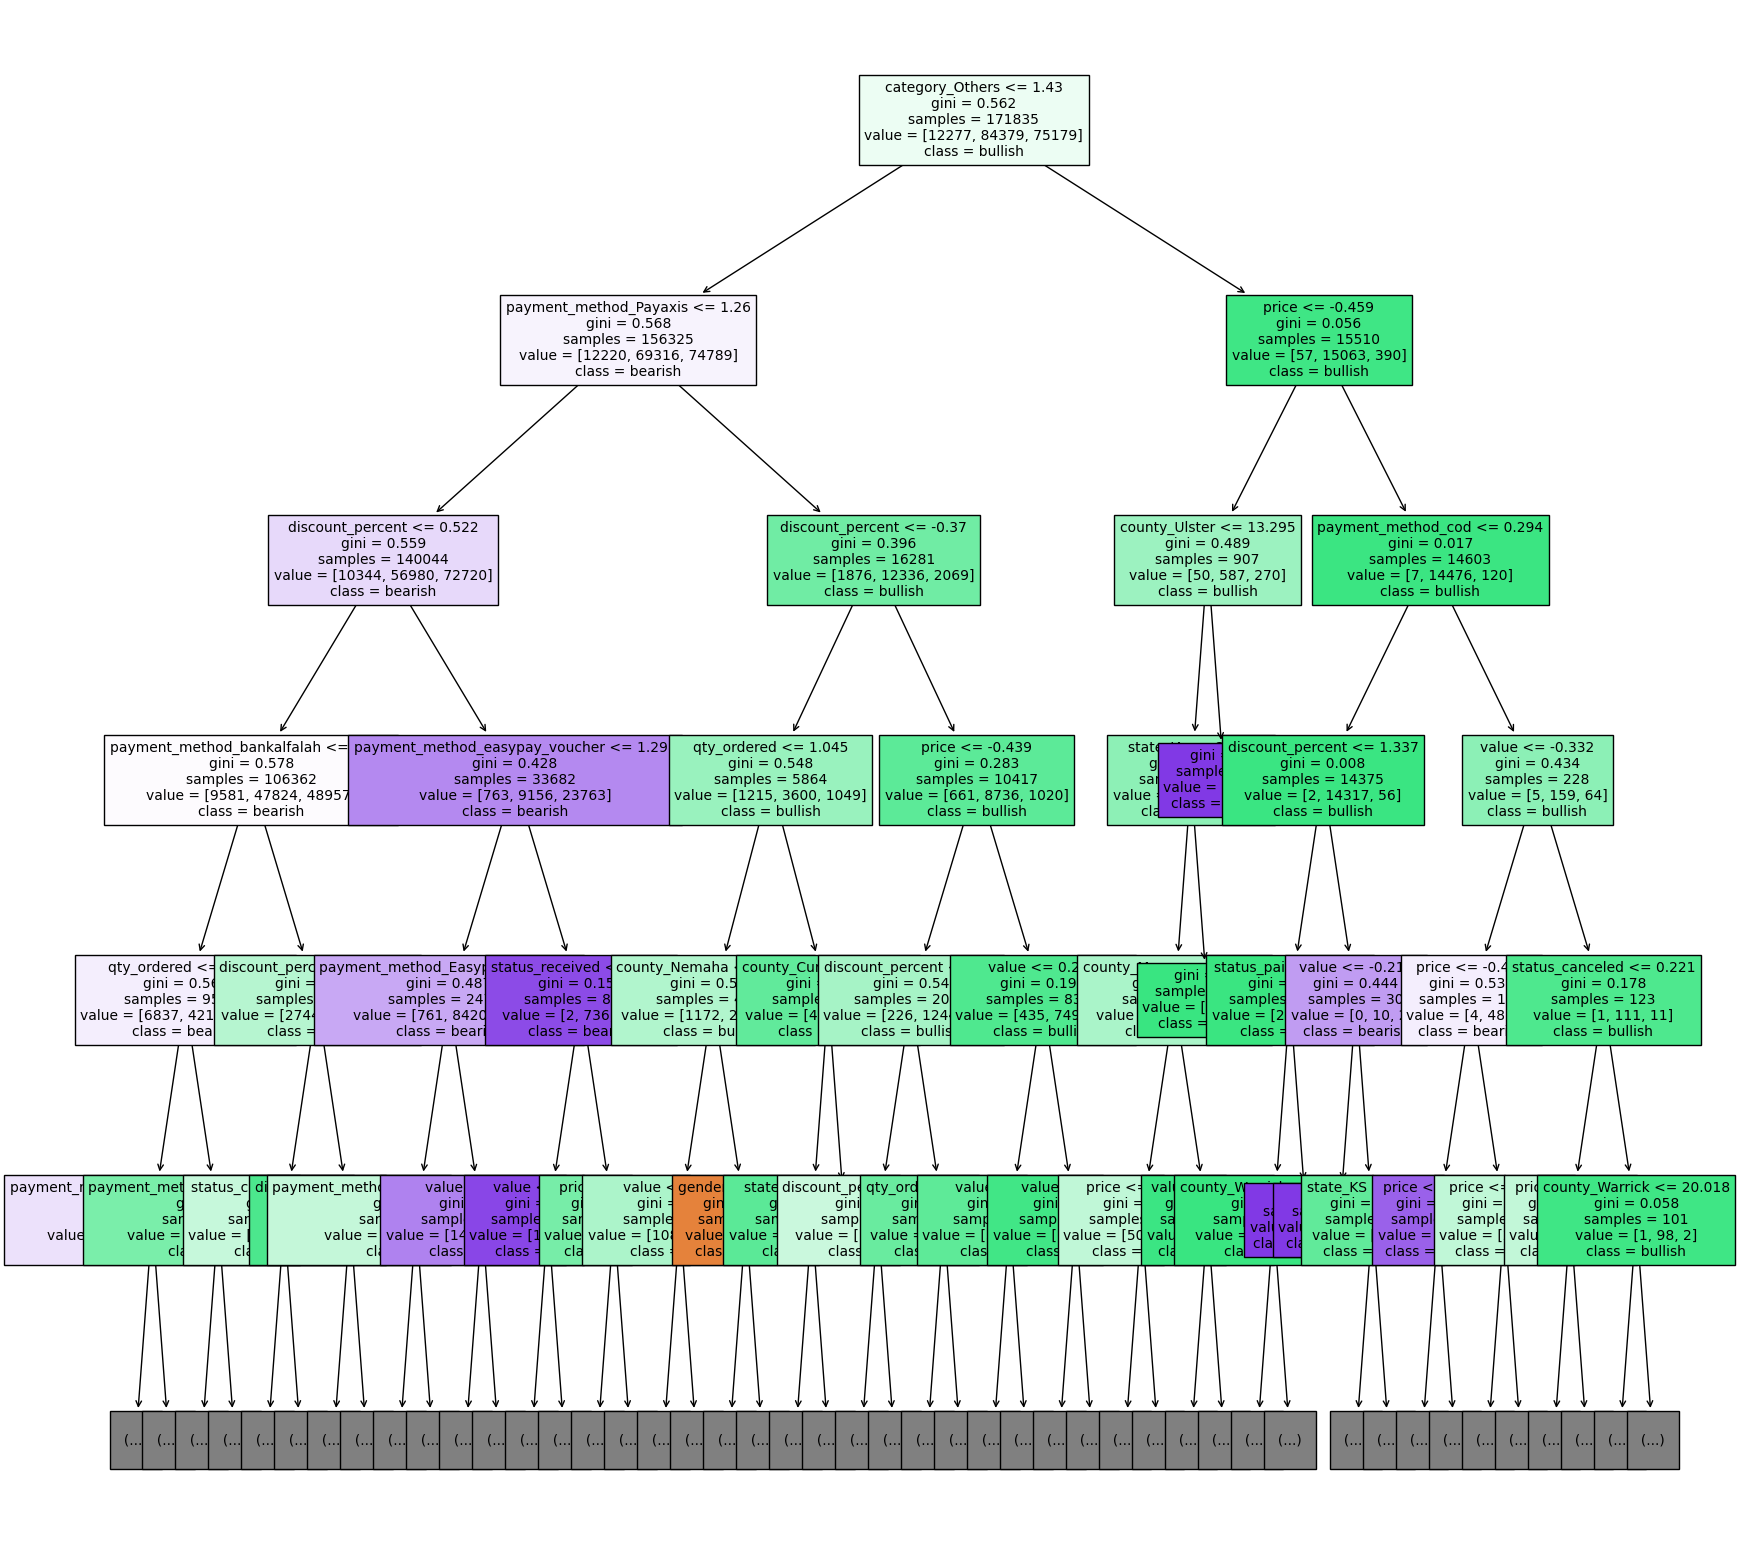

In [7]:
# Visualize one of the trees in the forest
# Visualize the decision tree
plt.figure(figsize=(20, 20))
clf = pipeline.named_steps['clf']
#plot_tree(clf, feature_names=X_train.columns, class_names=y_train.unique(), filled=True)
#plt.show()

#plot_tree(clf)

plot_tree(clf, filled=True, max_depth=5, fontsize=10, feature_names=X_train.columns, class_names=y_train.unique())
plt.show()

In [8]:
import pickle

# Save the model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(clf, f)